In [82]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [1]:
import os
import sys
import random
from time import time

import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from model.KGAT import KGAT
from parser.parser_kgat import *
from utils.log_helper import *
from utils.metrics import *
from utils.model_helper import *
from data_loader.loader_kgat import DataLoaderKGAT

In [2]:
def evaluate(model, dataloader, Ks, device):
    test_batch_size = dataloader.test_batch_size
    train_user_dict = dataloader.train_user_dict
    test_user_dict = dataloader.test_user_dict

    model.eval()

    user_ids = list(test_user_dict.keys())
    user_ids_batches = [user_ids[i: i + test_batch_size] for i in range(0, len(user_ids), test_batch_size)]
    user_ids_batches = [torch.LongTensor(d) for d in user_ids_batches]

    n_items = dataloader.n_items
    item_ids = torch.arange(n_items, dtype=torch.long).to(device)

    cf_scores = []
    metric_names = ['precision', 'recall', 'ndcg']
    metrics_dict = {k: {m: [] for m in metric_names} for k in Ks}

    with tqdm(total=len(user_ids_batches), desc='Evaluating Iteration') as pbar:
        for batch_user_ids in user_ids_batches:
            batch_user_ids = batch_user_ids.to(device)

            with torch.no_grad():
                batch_scores = model(batch_user_ids, item_ids, mode='predict')       # (n_batch_users, n_items)

            batch_scores = batch_scores.cpu()
            batch_metrics = calc_metrics_at_k(batch_scores, train_user_dict, test_user_dict, batch_user_ids.cpu().numpy(), item_ids.cpu().numpy(), Ks)

            cf_scores.append(batch_scores.numpy())
            for k in Ks:
                for m in metric_names:
                    metrics_dict[k][m].append(batch_metrics[k][m])
            pbar.update(1)

    cf_scores = np.concatenate(cf_scores, axis=0)
    for k in Ks:
        for m in metric_names:
            metrics_dict[k][m] = np.concatenate(metrics_dict[k][m]).mean()
    return cf_scores, metrics_dict

In [3]:
def train(args):
    # seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    log_save_id = create_log_id(args.save_dir)
    logging_config(folder=args.save_dir, name='log{:d}'.format(log_save_id), no_console=False)
    logging.info(args)

    # GPU / CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)
    if args.use_pretrain == 1:
        user_pre_embed = torch.tensor(data.user_pre_embed)
        item_pre_embed = torch.tensor(data.item_pre_embed)
    else:
        user_pre_embed, item_pre_embed = None, None

    # construct model & optimizer
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in, user_pre_embed, item_pre_embed)
    if args.use_pretrain == 2:
        model = load_model(model, args.pretrain_model_path)

    model.to(device)
    logging.info(model)

    cf_optimizer = optim.Adam(model.parameters(), lr=args.lr)
    kg_optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # initialize metrics
    best_epoch = -1
    best_recall = 0

    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    epoch_list = []
    metrics_list = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in Ks}

    # train model
    for epoch in range(1, args.n_epoch + 1):
        time0 = time()
        model.train()

        # train cf
        time1 = time()
        cf_total_loss = 0
        n_cf_batch = data.n_cf_train // data.cf_batch_size + 1

        for iter in range(1, n_cf_batch + 1):
            time2 = time()
            cf_batch_user, cf_batch_pos_item, cf_batch_neg_item = data.generate_cf_batch(data.train_user_dict, data.cf_batch_size)
            cf_batch_user = cf_batch_user.to(device)
            cf_batch_pos_item = cf_batch_pos_item.to(device)
            cf_batch_neg_item = cf_batch_neg_item.to(device)

            cf_batch_loss = model(cf_batch_user, cf_batch_pos_item, cf_batch_neg_item, mode='train_cf')

            if np.isnan(cf_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (CF Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_cf_batch))
                sys.exit()

            cf_batch_loss.backward()
            cf_optimizer.step()
            cf_optimizer.zero_grad()
            cf_total_loss += cf_batch_loss.item()

            if (iter % args.cf_print_every) == 0:
                logging.info('CF Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_cf_batch, time() - time2, cf_batch_loss.item(), cf_total_loss / iter))
        logging.info('CF Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_cf_batch, time() - time1, cf_total_loss / n_cf_batch))

        # train kg
        time3 = time()
        kg_total_loss = 0
        n_kg_batch = data.n_kg_train // data.kg_batch_size + 1

        for iter in range(1, n_kg_batch + 1):
            time4 = time()
            kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail = data.generate_kg_batch(data.train_kg_dict, data.kg_batch_size, data.n_users_entities)
            kg_batch_head = kg_batch_head.to(device)
            kg_batch_relation = kg_batch_relation.to(device)
            kg_batch_pos_tail = kg_batch_pos_tail.to(device)
            kg_batch_neg_tail = kg_batch_neg_tail.to(device)

            kg_batch_loss = model(kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail, mode='train_kg')

            if np.isnan(kg_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (KG Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_kg_batch))
                sys.exit()

            kg_batch_loss.backward()
            kg_optimizer.step()
            kg_optimizer.zero_grad()
            kg_total_loss += kg_batch_loss.item()

            if (iter % args.kg_print_every) == 0:
                logging.info('KG Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_kg_batch, time() - time4, kg_batch_loss.item(), kg_total_loss / iter))
        logging.info('KG Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_kg_batch, time() - time3, kg_total_loss / n_kg_batch))

        # update attention
        time5 = time()
        h_list = data.h_list.to(device)
        t_list = data.t_list.to(device)
        r_list = data.r_list.to(device)
        relations = list(data.laplacian_dict.keys())
        model(h_list, t_list, r_list, relations, mode='update_att')
        logging.info('Update Attention: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time5))

        logging.info('CF + KG Training: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time0))

        # evaluate cf
        if (epoch % args.evaluate_every) == 0 or epoch == args.n_epoch:
            time6 = time()
            _, metrics_dict = evaluate(model, data, Ks, device)
            logging.info('CF Evaluation: Epoch {:04d} | Total Time {:.1f}s | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
                epoch, time() - time6, metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))

            epoch_list.append(epoch)
            for k in Ks:
                for m in ['precision', 'recall', 'ndcg']:
                    metrics_list[k][m].append(metrics_dict[k][m])
            best_recall, should_stop = early_stopping(metrics_list[k_min]['recall'], args.stopping_steps)

            if should_stop:
                break

            if metrics_list[k_min]['recall'].index(best_recall) == len(epoch_list) - 1:
                save_model(model, args.save_dir, epoch, best_epoch)
                logging.info('Save model on epoch {:04d}!'.format(epoch))
                best_epoch = epoch

    # save metrics
    metrics_df = [epoch_list]
    metrics_cols = ['epoch_idx']
    for k in Ks:
        for m in ['precision', 'recall', 'ndcg']:
            metrics_df.append(metrics_list[k][m])
            metrics_cols.append('{}@{}'.format(m, k))
    metrics_df = pd.DataFrame(metrics_df).transpose()
    metrics_df.columns = metrics_cols
    metrics_df.to_csv(args.save_dir + '/metrics.tsv', sep='\t', index=False)

    # print best metrics
    best_metrics = metrics_df.loc[metrics_df['epoch_idx'] == best_epoch].iloc[0].to_dict()
    logging.info('Best CF Evaluation: Epoch {:04d} | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        int(best_metrics['epoch_idx']), best_metrics['precision@{}'.format(k_min)], best_metrics['precision@{}'.format(k_max)], best_metrics['recall@{}'.format(k_min)], best_metrics['recall@{}'.format(k_max)], best_metrics['ndcg@{}'.format(k_min)], best_metrics['ndcg@{}'.format(k_max)]))


In [4]:
def predict(args):
    # GPU / CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)

    # load model
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations)
    model = load_model(model, args.pretrain_model_path)
    model.to(device)

    # predict
    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    cf_scores, metrics_dict = evaluate(model, data, Ks, device)
    np.save(args.save_dir + 'cf_scores.npy', cf_scores)
    print('CF Evaluation: Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))

In [5]:
if __name__ == '__main__':
    args = parse_kgat_args()
    train(args)
    # predict(args)

2022-09-17 11:00:13,376 - root - INFO - Namespace(seed=2019, data_name='amazon-book', data_dir='datasets/', use_pretrain=1, pretrain_embedding_dir='datasets/pretrain/', pretrain_model_path='trained_model/model.pth', cf_batch_size=1024, kg_batch_size=2048, test_batch_size=10000, embed_dim=64, relation_dim=64, laplacian_type='random-walk', aggregation_type='bi-interaction', conv_dim_list='[64, 32, 16]', mess_dropout='[0.1, 0.1, 0.1]', kg_l2loss_lambda=1e-05, cf_l2loss_lambda=1e-05, lr=0.0001, n_epoch=1000, stopping_steps=10, cf_print_every=1, kg_print_every=1, evaluate_every=10, Ks='[20, 40, 60, 80, 100]', save_dir='trained_model/KGAT/amazon-book/embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain1/')


All logs will be saved to trained_model/KGAT/amazon-book/embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain1/log2.log


2022-09-17 11:01:38,295 - root - INFO - n_users:           70679
2022-09-17 11:01:38,297 - root - INFO - n_items:           24915
2022-09-17 11:01:38,298 - root - INFO - n_entities:        113487
2022-09-17 11:01:38,298 - root - INFO - n_users_entities:  184166
2022-09-17 11:01:38,298 - root - INFO - n_relations:       80
2022-09-17 11:01:38,299 - root - INFO - n_h_list:          6420520
2022-09-17 11:01:38,300 - root - INFO - n_t_list:          6420520
2022-09-17 11:01:38,300 - root - INFO - n_r_list:          6420520
2022-09-17 11:01:38,300 - root - INFO - n_cf_train:        652514
2022-09-17 11:01:38,300 - root - INFO - n_cf_test:         193920
2022-09-17 11:01:38,300 - root - INFO - n_kg_train:        6420520
/Users/ahnkwanki/src-github/KGAT-pytorch/data_loader/loader_kgat.py:118: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1.0).flatten()
2022-09-17 11:01:41,735 - root - INFO - KGAT(
  (entity_user_embed): Embedding(184166, 64)
  (relation_embed

2022-09-17 11:02:23,216 - root - INFO - CF Training: Epoch 0001 Iter 0048 / 0638 | Time 0.8s | Iter Loss 0.0222 | Iter Mean Loss 0.0259
2022-09-17 11:02:24,027 - root - INFO - CF Training: Epoch 0001 Iter 0049 / 0638 | Time 0.8s | Iter Loss 0.0234 | Iter Mean Loss 0.0259
2022-09-17 11:02:25,167 - root - INFO - CF Training: Epoch 0001 Iter 0050 / 0638 | Time 1.1s | Iter Loss 0.0256 | Iter Mean Loss 0.0259
2022-09-17 11:02:26,312 - root - INFO - CF Training: Epoch 0001 Iter 0051 / 0638 | Time 1.1s | Iter Loss 0.0230 | Iter Mean Loss 0.0258
2022-09-17 11:02:27,346 - root - INFO - CF Training: Epoch 0001 Iter 0052 / 0638 | Time 1.0s | Iter Loss 0.0260 | Iter Mean Loss 0.0258
2022-09-17 11:02:28,419 - root - INFO - CF Training: Epoch 0001 Iter 0053 / 0638 | Time 1.1s | Iter Loss 0.0261 | Iter Mean Loss 0.0258
2022-09-17 11:02:29,526 - root - INFO - CF Training: Epoch 0001 Iter 0054 / 0638 | Time 1.1s | Iter Loss 0.0228 | Iter Mean Loss 0.0258
2022-09-17 11:02:31,703 - root - INFO - CF Train

2022-09-17 11:03:22,218 - root - INFO - CF Training: Epoch 0001 Iter 0109 / 0638 | Time 1.0s | Iter Loss 0.0223 | Iter Mean Loss 0.0255
2022-09-17 11:03:23,189 - root - INFO - CF Training: Epoch 0001 Iter 0110 / 0638 | Time 1.0s | Iter Loss 0.0273 | Iter Mean Loss 0.0255
2022-09-17 11:03:25,347 - root - INFO - CF Training: Epoch 0001 Iter 0111 / 0638 | Time 2.2s | Iter Loss 0.0228 | Iter Mean Loss 0.0255
2022-09-17 11:03:26,697 - root - INFO - CF Training: Epoch 0001 Iter 0112 / 0638 | Time 1.3s | Iter Loss 0.0231 | Iter Mean Loss 0.0255
2022-09-17 11:03:27,609 - root - INFO - CF Training: Epoch 0001 Iter 0113 / 0638 | Time 0.9s | Iter Loss 0.0246 | Iter Mean Loss 0.0255
2022-09-17 11:03:28,486 - root - INFO - CF Training: Epoch 0001 Iter 0114 / 0638 | Time 0.9s | Iter Loss 0.0276 | Iter Mean Loss 0.0255
2022-09-17 11:03:29,328 - root - INFO - CF Training: Epoch 0001 Iter 0115 / 0638 | Time 0.8s | Iter Loss 0.0257 | Iter Mean Loss 0.0255
2022-09-17 11:03:30,237 - root - INFO - CF Train

2022-09-17 11:04:22,204 - root - INFO - CF Training: Epoch 0001 Iter 0170 / 0638 | Time 0.9s | Iter Loss 0.0321 | Iter Mean Loss 0.0252
2022-09-17 11:04:23,113 - root - INFO - CF Training: Epoch 0001 Iter 0171 / 0638 | Time 0.9s | Iter Loss 0.0222 | Iter Mean Loss 0.0252
2022-09-17 11:04:24,034 - root - INFO - CF Training: Epoch 0001 Iter 0172 / 0638 | Time 0.9s | Iter Loss 0.0270 | Iter Mean Loss 0.0252
2022-09-17 11:04:25,029 - root - INFO - CF Training: Epoch 0001 Iter 0173 / 0638 | Time 1.0s | Iter Loss 0.0260 | Iter Mean Loss 0.0252
2022-09-17 11:04:25,913 - root - INFO - CF Training: Epoch 0001 Iter 0174 / 0638 | Time 0.9s | Iter Loss 0.0215 | Iter Mean Loss 0.0252
2022-09-17 11:04:26,818 - root - INFO - CF Training: Epoch 0001 Iter 0175 / 0638 | Time 0.9s | Iter Loss 0.0232 | Iter Mean Loss 0.0252
2022-09-17 11:04:27,687 - root - INFO - CF Training: Epoch 0001 Iter 0176 / 0638 | Time 0.9s | Iter Loss 0.0224 | Iter Mean Loss 0.0252
2022-09-17 11:04:28,546 - root - INFO - CF Train

KeyboardInterrupt: 

# DataLoaderKGAT(DataLoaderBase)

In [142]:
args = parse_kgat_args()

# Custom args for testing
args.use_pretrain = 0

display(args)

Namespace(seed=2019, data_name='amazon-book', data_dir='datasets/', use_pretrain=0, pretrain_embedding_dir='datasets/pretrain/', pretrain_model_path='trained_model/model.pth', cf_batch_size=1024, kg_batch_size=2048, test_batch_size=10000, embed_dim=64, relation_dim=64, laplacian_type='random-walk', aggregation_type='bi-interaction', conv_dim_list='[64, 32, 16]', mess_dropout='[0.1, 0.1, 0.1]', kg_l2loss_lambda=1e-05, cf_l2loss_lambda=1e-05, lr=0.0001, n_epoch=1000, stopping_steps=10, cf_print_every=1, kg_print_every=1, evaluate_every=10, Ks='[20, 40, 60, 80, 100]', save_dir='trained_model/KGAT/amazon-book/embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain1/')

In [124]:
kg_data = data.load_kg(data.kg_file)

In [126]:
data.kg_file

'datasets/amazon-book/kg_final.txt'

In [160]:
def printFileLineNumber(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    print(len(lines))
printFileLineNumber(filename='datasets/amazon-book/entity_list.txt')
printFileLineNumber(filename='datasets/amazon-book/item_list.txt')
printFileLineNumber(filename='datasets/amazon-book/relation_list.txt')
printFileLineNumber(filename='datasets/amazon-book/user_list.txt')
printFileLineNumber(filename='datasets/amazon-book/kg_final.txt')
printFileLineNumber(filename='datasets/amazon-book/train.txt')
printFileLineNumber(filename='datasets/amazon-book/test.txt')

113488
24916
40
70680
2557746
70679
70679


In [151]:
with open('datasets/amazon-book/train.txt', "r") as f:
    lines = f.readlines()
    for line in lines:
        if "226974" in line:
            print(line)
print(len(lines))

70679


In [125]:
display(kg_data)

,h,r,t
0,24915,0,24916
1,24917,1,5117
2,24918,0,24917
3,24919,1,24920
4,24921,2,24922
...,...,...,...
2557741,55167,3,24942
2557742,24925,1,67332
2557743,41753,0,24942
2557744,24923,1,97956


In [63]:
kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,h,r,t
count,2557746.00,2557746.00,2557746.00
mean,45356.63,2.93,34726.32
std,30735.92,3.85,23555.93
min,0.00,0.00,0.00
25%,24917.00,0.00,24917.00
50%,29917.00,1.00,24925.00
75%,69850.00,3.00,28932.00
max,113486.00,38.00,113486.00


In [64]:
sorted(kg_data["h"].tolist()) == sorted(kg_data["t"].tolist())

False

array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

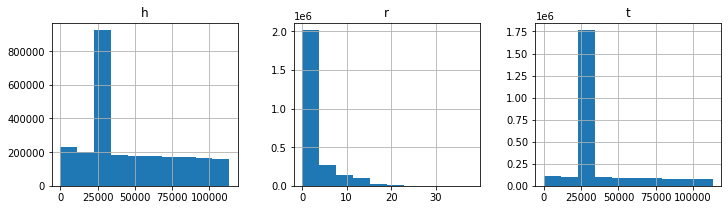

In [87]:
display(kg_data.hist(figsize=(12,3), layout=(1,3)))

In [88]:
# def construct_data(kg_data)

# add inverse kg data ???
n_relations = max(kg_data['r']) + 1
inverse_kg_data = kg_data.copy()
inverse_kg_data = inverse_kg_data.rename({'h': 't', 't': 'h'}, axis='columns')
inverse_kg_data['r'] += n_relations
kg_data = pd.concat([kg_data, inverse_kg_data], axis=0, ignore_index=True, sort=False)

In [89]:
kg_data.shape, inverse_kg_data.shape

((5115492, 3), (2557746, 3))

In [91]:
kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,h,r,t
count,5115492.00,5115492.00,5115492.00
mean,40041.48,22.43,40041.48
std,27893.37,19.88,27893.37
min,0.00,0.00,0.00
25%,24917.00,1.00,24917.00
50%,24942.00,38.50,24942.00
75%,55227.00,40.00,55227.00
max,113486.00,77.00,113486.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

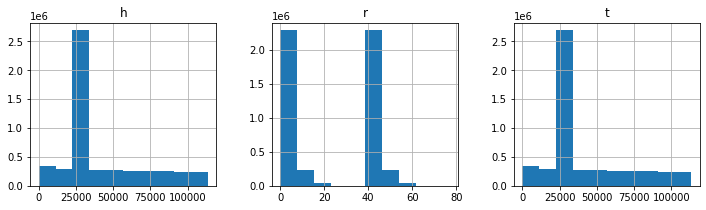

In [90]:
display(kg_data.hist(figsize=(12,3), layout=(1,3)))

In [94]:
from data_loader.loader_base import DataLoaderBase

loaderBase = DataLoaderBase(args, logging)

In [159]:
data.n_relations, data.n_entities, data.n_users_entities

(80, 113487, 184166)

In [156]:
cf_train_data[0].shape, cf_test_data

((652514,),
 (array([226974, 226974, 226974, ..., 297651, 297652, 297652], dtype=int32),
  array([22435,  7460,   774, ..., 10577, 17865, 20557], dtype=int32)))

In [155]:
keys = train_user_dict.keys()
min(keys), max(keys)

(226974, 297652)

In [139]:
# re-map user id
kg_data['r'] += 2
n_relations = max(kg_data['r']) + 1
n_entities = max(max(kg_data['h']), max(kg_data['t'])) + 1
n_users_entities = n_users + n_entities

cf_train_data = (np.array(list(map(lambda d: d + n_entities, cf_train_data[0]))).astype(np.int32), cf_train_data[1].astype(np.int32))
cf_test_data = (np.array(list(map(lambda d: d + n_entities, cf_test_data[0]))).astype(np.int32), cf_test_data[1].astype(np.int32))

train_user_dict = {k + n_entities: np.unique(v).astype(np.int32) for k, v in train_user_dict.items()}
test_user_dict = {k + n_entities: np.unique(v).astype(np.int32) for k, v in test_user_dict.items()}

In [ ]:
# add interactions to kg data
cf2kg_train_data = pd.DataFrame(np.zeros((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
cf2kg_train_data['h'] = self.cf_train_data[0]
cf2kg_train_data['t'] = self.cf_train_data[1]

inverse_cf2kg_train_data = pd.DataFrame(np.ones((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
inverse_cf2kg_train_data['h'] = self.cf_train_data[1]
inverse_cf2kg_train_data['t'] = self.cf_train_data[0]

self.kg_train_data = pd.concat([kg_data, cf2kg_train_data, inverse_cf2kg_train_data], ignore_index=True)
self.n_kg_train = len(self.kg_train_data)

# construct kg dict
h_list = []
t_list = []
r_list = []

self.train_kg_dict = collections.defaultdict(list)
self.train_relation_dict = collections.defaultdict(list)

for row in self.kg_train_data.iterrows():
    h, r, t = row[1]
    h_list.append(h)
    t_list.append(t)
    r_list.append(r)

    self.train_kg_dict[h].append((t, r))
    self.train_relation_dict[r].append((h, t))

self.h_list = torch.LongTensor(h_list)
self.t_list = torch.LongTensor(t_list)
self.r_list = torch.LongTensor(r_list)